# Stats Based Anomaly Detection

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [2]:
df = pd.read_csv("/kaggle/input/beijing-pm25-data-data-set/PRSA_data_2010.1.1-2014.12.31.csv")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df = df[["pm2.5", "year", "month", "day", "hour"]].dropna()

# Datetime index


In [4]:
df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df = df.set_index("timestamp").sort_index()

# Z-score


In [5]:
mean_val = df["pm2.5"].mean()
std_val = df["pm2.5"].std()

df["zscore"] = (df["pm2.5"] - mean_val) / std_val
df["anomaly_z"] = (df["zscore"].abs() > 3).astype(int)

print("Outliers detected:", df["anomaly_z"].sum())

Outliers detected: 769


# Plot

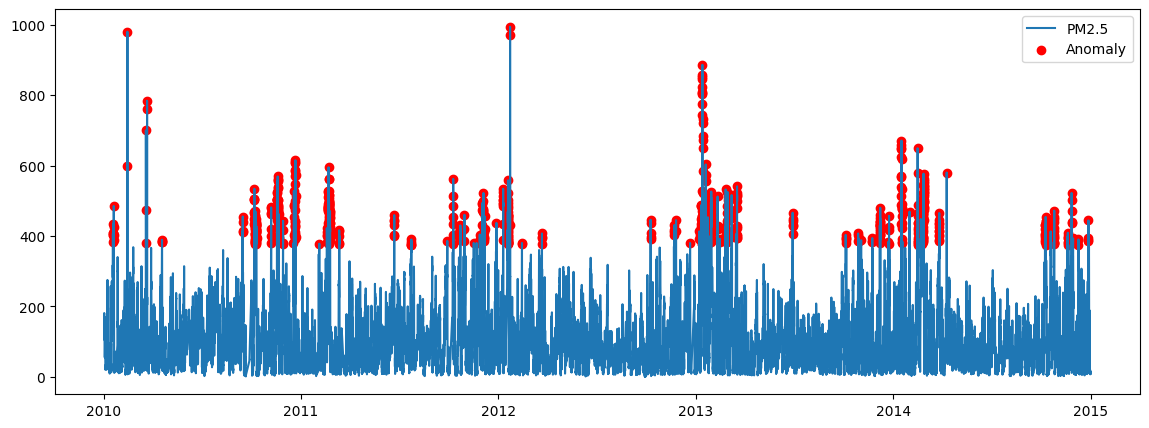

In [6]:
plt.figure(figsize=(14,5))
plt.plot(df["pm2.5"], label="PM2.5")
plt.scatter(df[df["anomaly_z"]==1].index,
            df[df["anomaly_z"]==1]["pm2.5"],
            color='red', label="Anomaly")
plt.legend()
plt.show()

# Validation

In [7]:
def evaluate_anomalies(df, label):
    total = len(df)
    anomalies = df[label].sum()
    pct = (anomalies / total) * 100
    
    print(f"Total points: {total}")
    print(f"Anomalies detected: {anomalies} ({pct:.2f}%)")

evaluate_anomalies(df, "anomaly_z")

Total points: 41757
Anomalies detected: 769 (1.84%)


# IQR (INTERQUARTILE RANGE) OUTLIER DETECTION

In [8]:
Q1 = df["pm2.5"].quantile(0.25)
Q3 = df["pm2.5"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["anomaly_iqr"] = ((df["pm2.5"] < lower) | (df["pm2.5"] > upper)).astype(int)

print("IQR anomalies:", df["anomaly_iqr"].sum())

IQR anomalies: 1773


# Plot using IQR


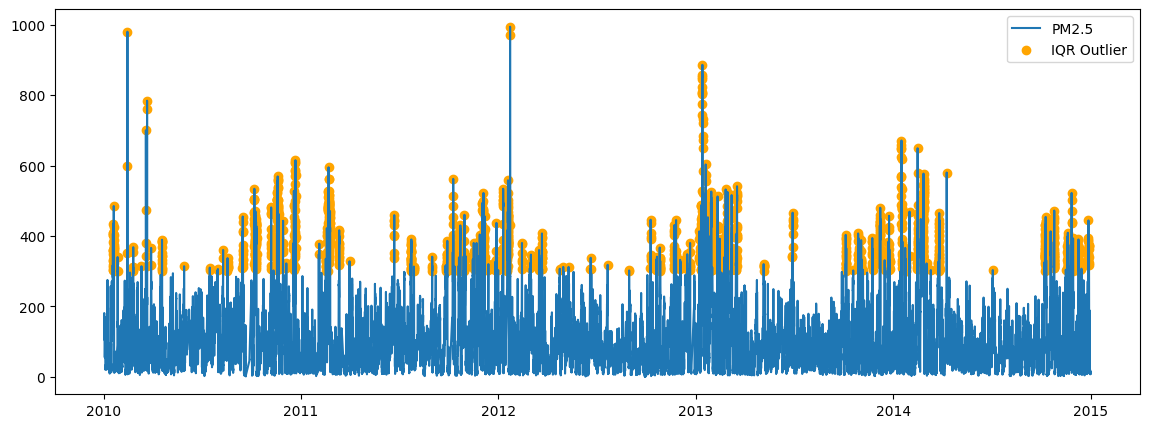

In [9]:
plt.figure(figsize=(14,5))
plt.plot(df["pm2.5"], label="PM2.5")
plt.scatter(df[df["anomaly_iqr"]==1].index,
            df[df["anomaly_iqr"]==1]["pm2.5"],
            color='orange', label="IQR Outlier")
plt.legend()
plt.show()

# Validate for IQR

In [10]:
evaluate_anomalies(df, "anomaly_iqr")

Total points: 41757
Anomalies detected: 1773 (4.25%)


# ROLLING STATS ANOMALY DETECTION (MOVING AVG + MOVING STD)

In [11]:
window = 24  

df["roll_mean"] = df["pm2.5"].rolling(window).mean()
df["roll_std"] = df["pm2.5"].rolling(window).std()

df["upper"] = df["roll_mean"] + 3 * df["roll_std"]
df["lower"] = df["roll_mean"] - 3 * df["roll_std"]

df["anomaly_roll"] = ((df["pm2.5"] > df["upper"]) | (df["pm2.5"] < df["lower"])).astype(int)

print("Rolling anomalies:", df["anomaly_roll"].sum())

Rolling anomalies: 731


# Plot using Rolling Stats


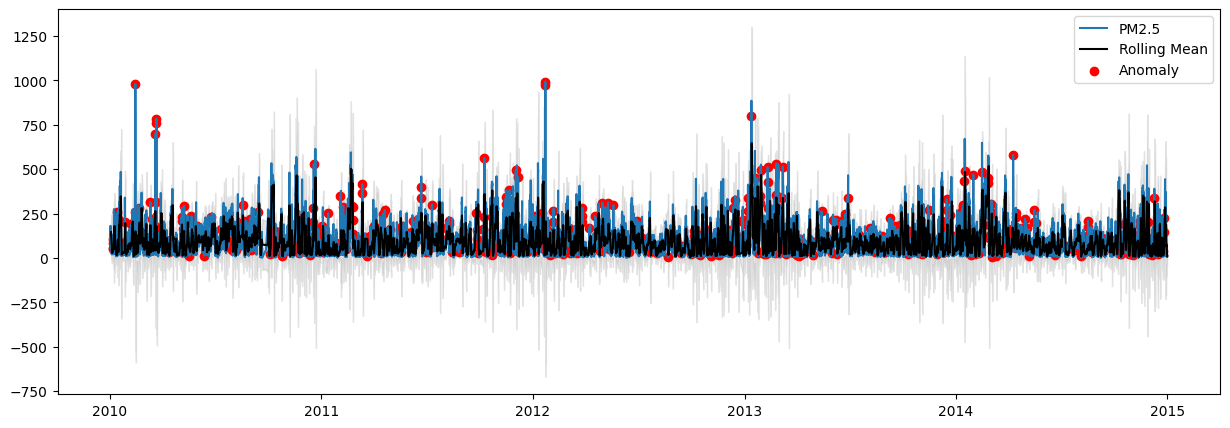

In [12]:
plt.figure(figsize=(15,5))
plt.plot(df["pm2.5"], label="PM2.5")
plt.plot(df["roll_mean"], label="Rolling Mean", color='black')
plt.fill_between(df.index, df["upper"], df["lower"], color='gray', alpha=0.2)
plt.scatter(df[df["anomaly_roll"]==1].index,
            df[df["anomaly_roll"]==1]["pm2.5"],
            color='red', label="Anomaly")
plt.legend()
plt.show()


In [13]:
evaluate_anomalies(df, "anomaly_roll")

Total points: 41757
Anomalies detected: 731 (1.75%)
